In [84]:
import os
import warnings
import re
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from dotenv import load_dotenv

from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core import (
    load_index_from_storage,
    StorageContext,
    Document,
    VectorStoreIndex,
    get_response_synthesizer
)

from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

import sys
import tensorflow as tf
from tensorflow.keras import preprocessing
sys.modules['keras.src.preprocessing'] = preprocessing

In [2]:
warnings.filterwarnings('ignore')

# Loading Data
Nb: Used parquet instead of csv to preserve data type

In [3]:
df = pd.read_parquet('../data/data_clustered_tsne.parquet.gzip')

Nb: Pre-loaded tsne-2d and tsne-3d to not waste time processing.

In [4]:
df.head()

,id,source,title,content,embedding,tsne-2d-1,tsne-2d-2,cluster,tsne-3d-1,tsne-3d-2,tsne-3d-3
0,0,tempo,Kapolri Instruksikan Proses Tegas Kasus Suap P...,"TEMPO.CO, Yogyakarta- Kapolri Jenderal Listyo ...","[0.006670293, -0.008296051, 0.018612592, -0.01...",29.873199,1.401189,0,18.658846,6.101427,3.910203
1,1,tempo,"Terdampak Banjir, Mentan Siap Bantu Petani di ...",INFO NASIONAL - Menteri Pertanian Syahrul Yasi...,"[-0.013915301, -0.018322684, 0.012273976, -0.0...",-46.414150,-4.596785,2,-20.185184,-2.371418,-8.996706
2,2,tempo,"Kementan Upayakan Perizinan Mudah, Cepat, dan ...",INFO NASIONAL - Kementerian Pertanian memastik...,"[0.015555209, -0.015595161, -0.001956054, -0.0...",-50.386646,-3.093976,1,-21.070637,-2.328195,-5.975774
3,3,tempo,Wapres Maruf Amin Dorong Pengusaha Sawit Perku...,INFO NASIONAL Para pengusaha yang tergabung d...,"[0.0035903626, -0.015759699, 0.008853396, -0.0...",-50.196079,-0.174417,1,-23.908243,0.352373,-4.074963
4,4,tempo,Menpan RB: Minat ASN Muda Pindah ke IKN Nusant...,"TEMPO.CO, Malang - Menteri Pendayagunaan Apara...","[-0.00013789257, -0.03197872, 0.012931213, 0.0...",-13.652273,16.243923,1,-3.523464,4.716335,0.848294


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         32294 non-null  int64  
 1   source     32294 non-null  object 
 2   title      32294 non-null  object 
 3   content    32294 non-null  object 
 4   embedding  32294 non-null  object 
 5   tsne-2d-1  32294 non-null  float32
 6   tsne-2d-2  32294 non-null  float32
 7   cluster    32294 non-null  int32  
 8   tsne-3d-1  32294 non-null  float32
 9   tsne-3d-2  32294 non-null  float32
 10  tsne-3d-3  32294 non-null  float32
dtypes: float32(5), int32(1), int64(1), object(4)
memory usage: 2.0+ MB


In [6]:
load_dotenv('var.env')

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

embed_model = OpenAIEmbedding()

# Plotting

Convert to numpy

In [8]:
def convertEmbeddingStringToFloat(df, embedding_column):
     X = np.array(df[embedding_column].to_list(), dtype=np.float32)
     return X

Nb: Pre-converted embeddings to numpy to save loading time using convertEmbeddingStringToFloat

In [ ]:
# X = convertEmbeddingStringToFloat(df, 'embedding')

In [7]:
X = np.load('../data/embeddings.npy')

Add t-sne columns for plotting

In [10]:
def reduceDimension(X, perplexity, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=123, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    return tsne_results

In [11]:
def convertTSNEtoDF(df, tsne_results):
    dimension = tsne_results.shape[1]
    for i in range(dimension):
        df[f'tsne-{dimension}d-{i+1}'] = tsne_results[:,i]
    return df

In [ ]:
# tsne_results_2d = reduceDimension(X, 50)
# df = convertTSNEtoDF(df, tsne_results_2d)

# tsne_results_3d = reduceDimension(X, 50,  n_components=3)
# df = convertTSNEtoDF(df, tsne_results_3d)

Plotting

In [13]:
def plotTSNE2D(df, x_col, y_col, hue_col=None, highlight_points=None, title='t-SNE Plot Embedding'):
    fig, ax = plt.subplots(figsize=(8,6))

    if(hue_col=='cluster'):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='hls')
    else:
        sns.scatterplot(data=df, x=x_col, y=y_col, palette='hls')

    if(highlight_points!=None):
        highlight_points = df.iloc[highlight_points]
        sns.scatterplot(
            data=highlight_points, 
            x=x_col,
            y=y_col,
            color='black',
            s=50,
            ax=ax
        )

    plt.title(title)
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.axis('equal')
    plt.legend()
    plt.show()

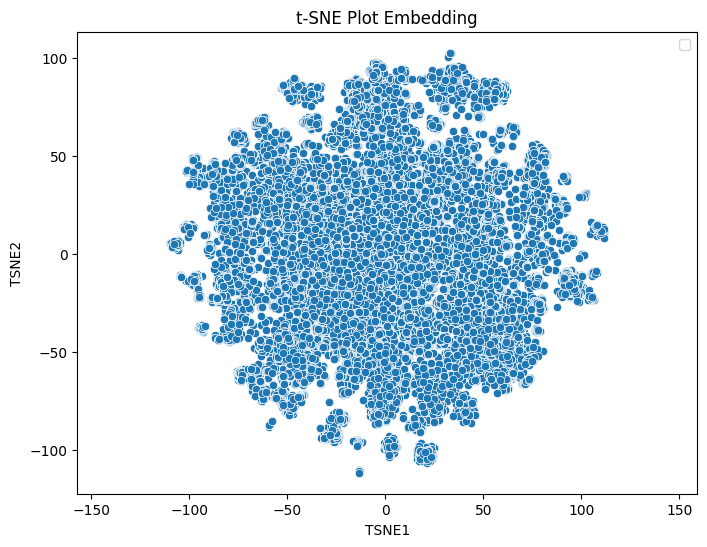

In [14]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2')

In [15]:
def plotTSNE3D(df, x_col, y_col, z_col, hue_col='id', highlight_points=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_colors = df[hue_col]
    sc = ax.scatter(df[x_col], df[y_col], df[z_col], c=cluster_colors, cmap='hsv')

    if(hue_col=='cluster'):
        colors = {0: 'blue', 1: 'orange', 2: 'green',3:'red', 4: 'purple', 5: 'brown'}
        cluster_colors = df[hue_col].map(colors)
        n_clusters = len(df[hue_col].unique())
        handles, labels = sc.legend_elements()
        ax.legend(handles, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters")
    else:
        cluster_colors = df[hue_col]

    plt.colorbar(sc)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title('3D t-SNE Visualization')
    
    if(highlight_points!=None ):
        highlight_points = df.iloc[highlight_points]
        ax.scatter(
            highlight_points[x_col],
            highlight_points[y_col],
            highlight_points[z_col],
            color='black',
            s=100
        )
    
    plt.show()

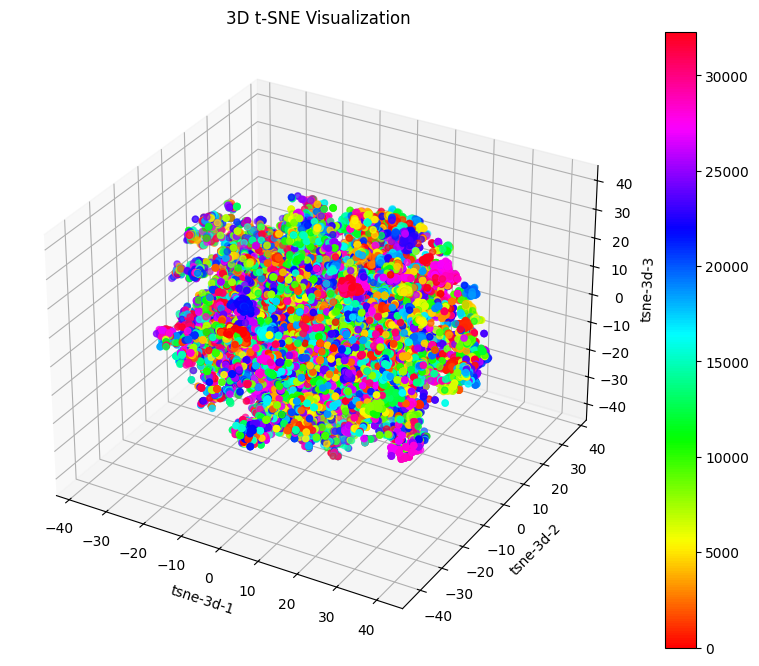

In [16]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3')

# K-Means Clustering

Elbow Method: Optimal K seems to be 3 for the steepest decline

In [17]:
def elbowMethod(X, start, end):
    inertia_values = []
    k_range = range(start, end)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_values, marker='o')
    plt.title('Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)

    plt.ylim(0, max(inertia_values) + (0.2 * max(inertia_values)))

    plt.show()

In [ ]:
elbowMethod(X, 1, 10)

Fitting K-Means (used 6 cluster as per company request)

In [19]:
kmeans = KMeans(n_clusters=6, random_state=123).fit(X)
# df['cluster'] =  kmeans.labels_ # Already ran this and saved in parquet. 

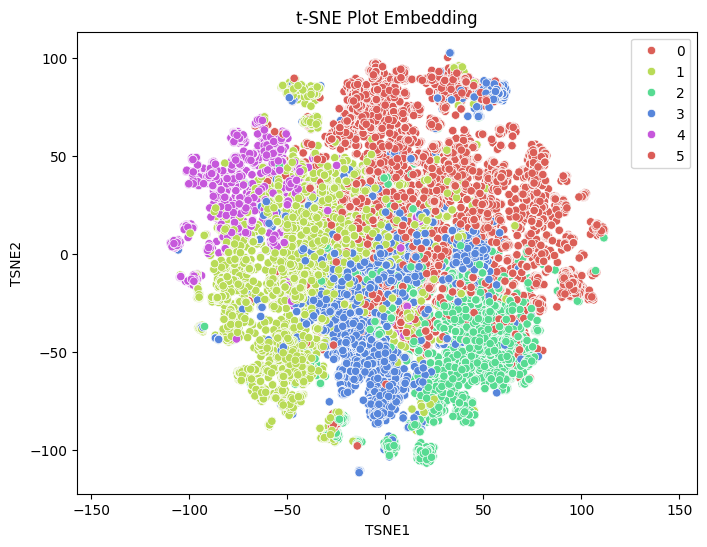

In [20]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster')

In [21]:
# # to make the plot interactive
# matplotlib widget

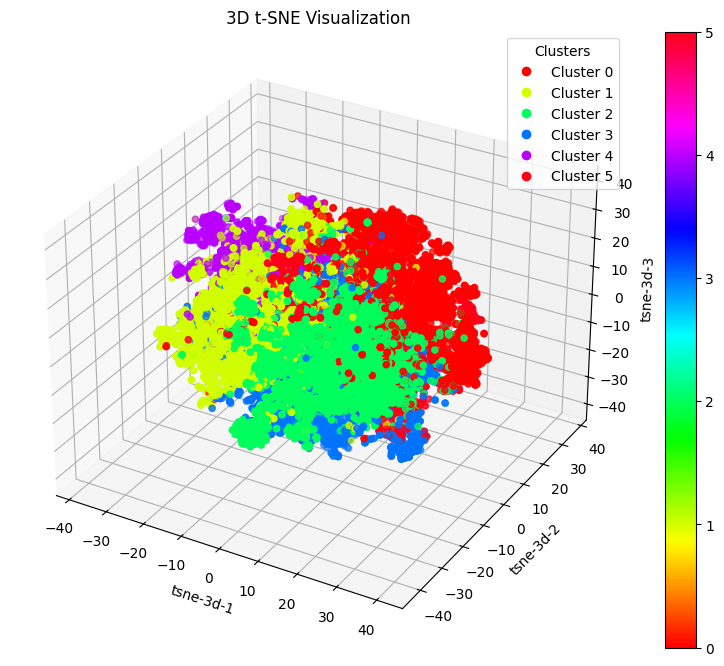

In [22]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster')

In [23]:
# # set it back so other graphs are not affected
# matplotlib inline

## Analyze Source Distribution

In [24]:
def countSource(df):
    source_count = df['source'].value_counts()
    return source_count

def countClusterSource(df):
    source_count = df.groupby(['cluster', 'source']).size().unstack(fill_value=0)
    return source_count

In [25]:
def plotSourceCount(df):
    source_count = countClusterSource(df)
    ax = source_count.plot(kind='bar', stacked=True, figsize=(12, 8))
    ax.set_title('Source Counts per Cluster', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Sources', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() 
    plt.show()

def plotSourceCountEachCluster(df):
    sourceCountEachCluster = pd.crosstab(df['source'], df['cluster'])
    n_clusters = len(df['cluster'].unique())
    n_rows, n_cols = 2, 4
    n_sources = len(sourceCountEachCluster.index)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten() # flatten the 2D array of axes to 1D
    
    for i, source in enumerate(sourceCountEachCluster.index):
        cluster_percentages = (sourceCountEachCluster.loc[source] / sourceCountEachCluster.loc[source].sum()) * 100
        
        ax = axes[i]
        ax.pie(
            cluster_percentages, 
            labels=[f'Cluster {j}' for j in range(n_clusters)], 
            autopct='%1.1f%%', 
            startangle=140
        )
        ax.set_title(source)

    for j in range(n_sources, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plotClusterDistribution(df):
    source_count = countClusterSource(df)
    source_majority_table = source_count.idxmax(axis=1)
    source_majority_table = source_majority_table.rename('Majority Cluster')
    summary_table = pd.DataFrame({
        'Biggest Source': source_majority_table,
        'Total Count': source_count.sum(axis=1)
    })    
    return summary_table

In [26]:
countSource(df)

source
kumparan         8571
okezone          7066
cnbcindonesia    4506
suara            4004
tempo            3642
cnnindonesia     3491
jawapos          1014
Name: count, dtype: int64

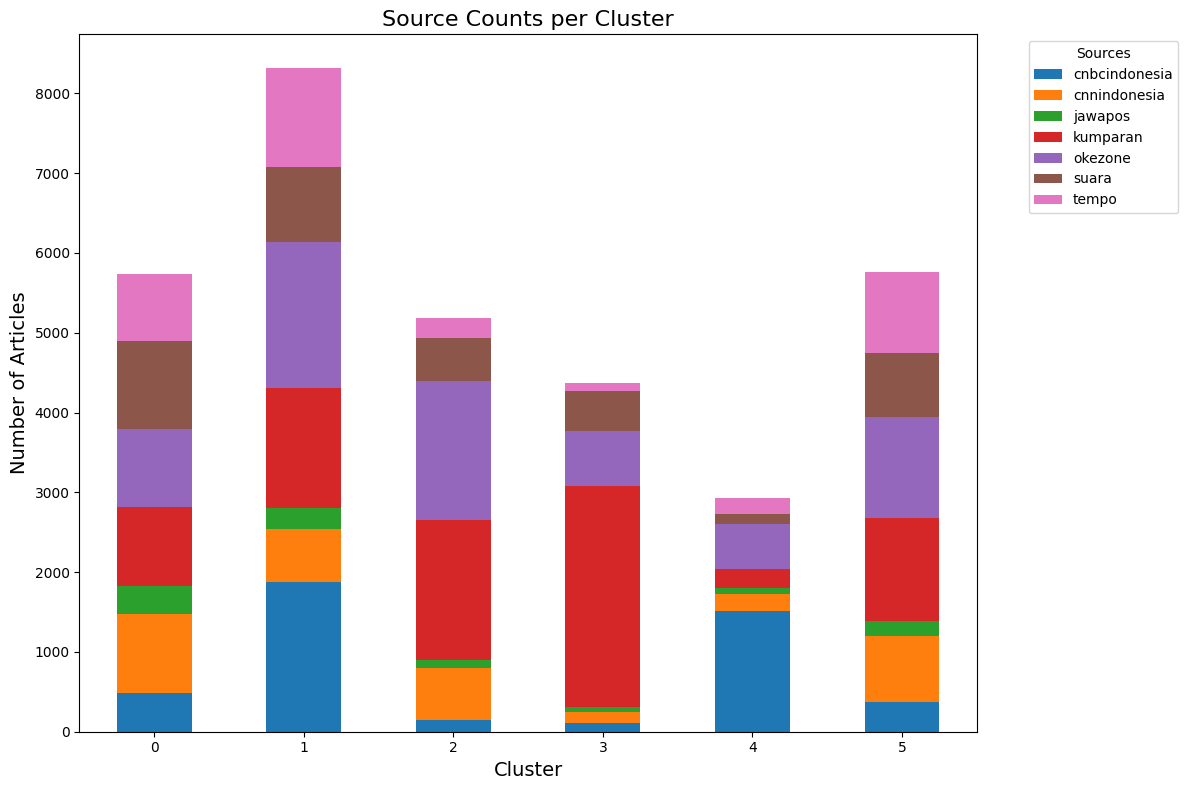

In [27]:
plotSourceCount(df)

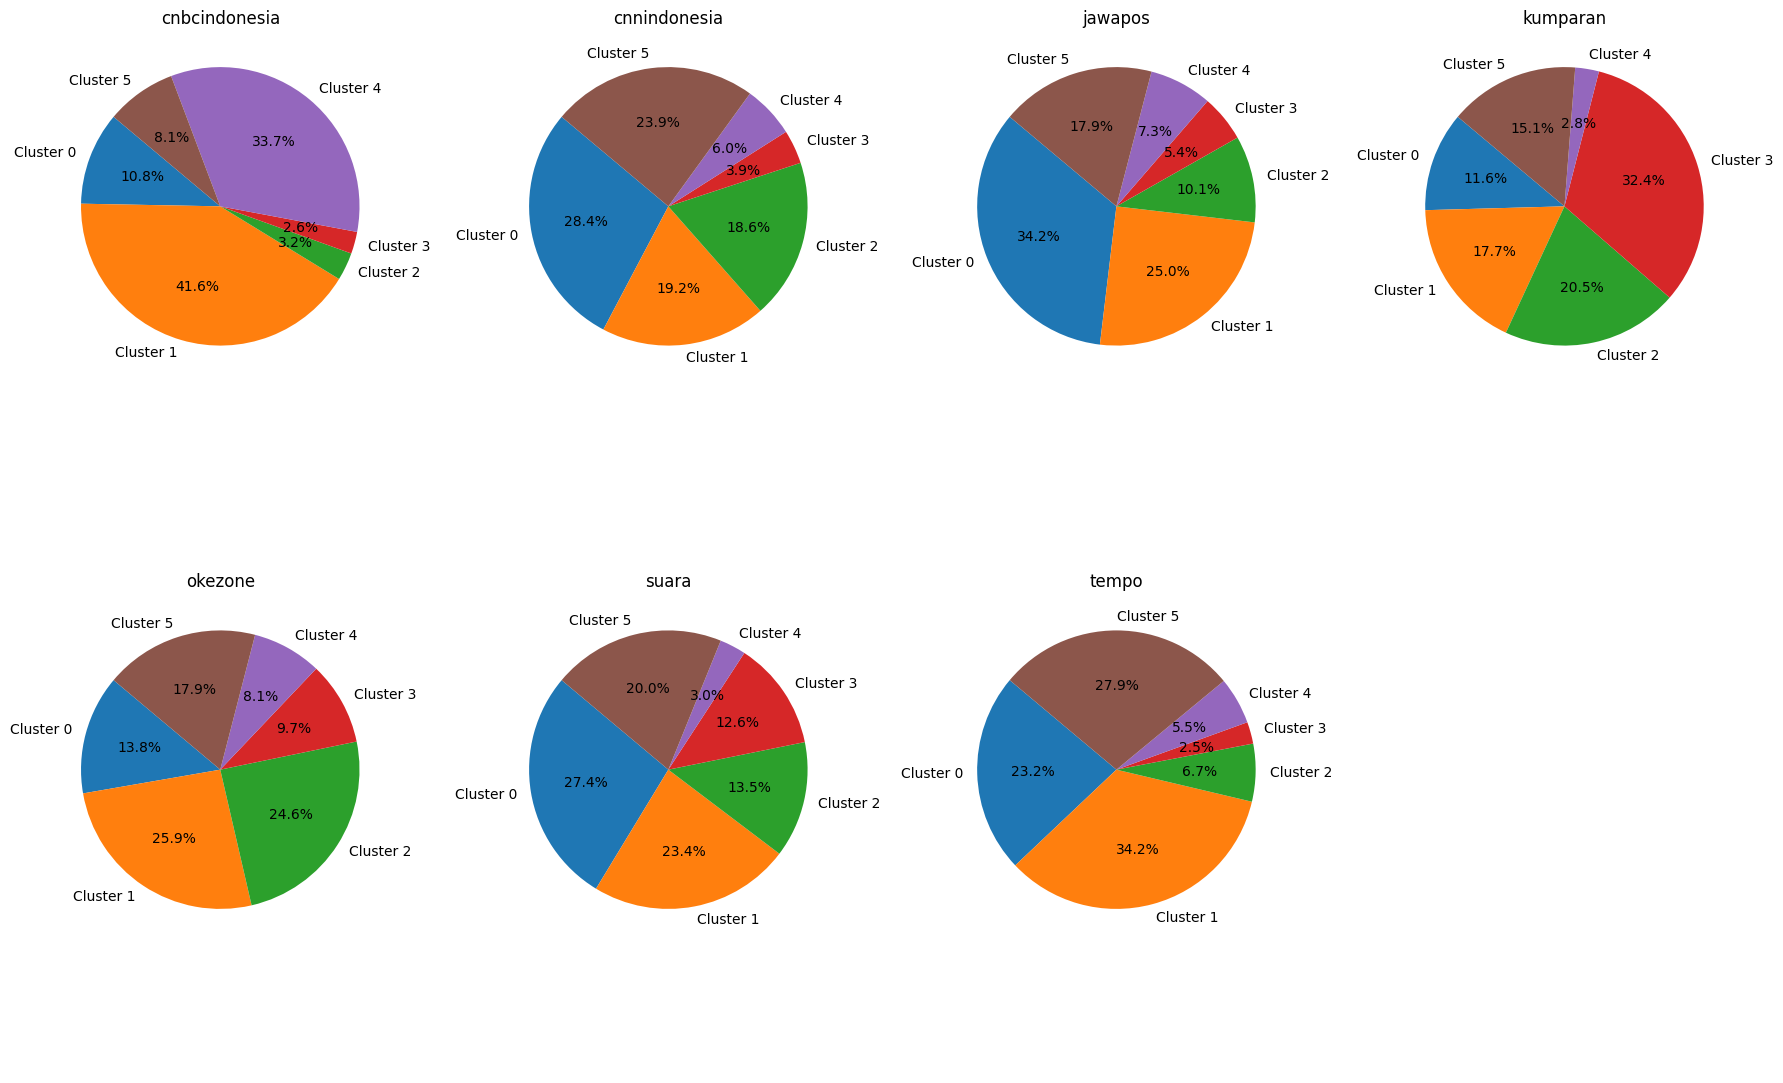

In [28]:
plotSourceCountEachCluster(df)

In [29]:
plotClusterDistribution(df)

,Biggest Source,Total Count
cluster,,
0,suara,5735
1,cnbcindonesia,8323
2,kumparan,5180
3,kumparan,4364
4,cnbcindonesia,2930
5,kumparan,5762


In [30]:
def createStopWordList(dir):
    stopWord_pd = pd.read_csv(dir, header=None)
    stopWordList = stopWord_pd[0].to_list()
    return stopWordList

def preprocessText(text, stopWordList):
    text = str(text)

    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'(@\w+|#\w+)', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'\s{2,}', ' ', text)
    
    words = text.split()

    words = [word for word in words if word not in stopWordList]

    return words

In [31]:
stopWordList = createStopWordList('../data/stopWordList.csv')

In [32]:
def wordCountEachCluster(df, stopWordList):
    clusterWordCount = {}
    for cluster in df['cluster'].unique():
        clusterArticles = df[df['cluster'] == cluster]['content']
        
        allWords = []
        for article in clusterArticles:
            allWords.extend(preprocessText(article, stopWordList))
        
        wordCount = Counter(allWords)
        clusterWordCount[cluster] = wordCount
        
    clusterWordCount = dict(sorted(clusterWordCount.items()))
    return clusterWordCount

def plotClusterWordCount(clusterWordCount, top_n=30):
    fig, axes = plt.subplots(nrows=len(clusterWordCount), figsize=(10, len(clusterWordCount)*6))

    for i, (cluster, word_counts) in enumerate(clusterWordCount.items()):
        top_words = word_counts.most_common(top_n)
        words, counts = zip(*top_words)
        
        ax = axes[i] if len(clusterWordCount) > 1 else axes
        ax.barh(words, counts)
        ax.set_title(f'Cluster {cluster} - Top {top_n} Words')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

In [ ]:
clusterWordCount = wordCountEachCluster(df, stopWordList)

In [ ]:
plotClusterWordCount(clusterWordCount, top_n=10)

# Research with Sample

In [35]:
def getNpEmbedding(embed_model, text):
    embedding = embed_model.get_text_embedding(text)
    return embedding, np.array(embedding, dtype=np.float32).reshape(1, -1)

def predictCluster(NpEmbedding, kmeans):
    predictedCluster = kmeans.predict(NpEmbedding)
    return predictedCluster

def getClusterCenter(kmeans):
    cluster_centers = kmeans.cluster_centers_
    return cluster_centers

def getDfofCluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

In [36]:
def topWordsinCluster(clusterWordCount, cluster, top_n=100):
    topWordsCluster = clusterWordCount[cluster].most_common(top_n)
    topWordsCount = {word: count for word, count in topWordsCluster}

    for word, count in list(topWordsCount.items())[:10]:
        print(f"{word}: {count}")

    return topWordsCount

def topSimilarWords(text, pc, stopWordList, topWordsCount):
    textWords = preprocessText(text, stopWordList)

    textWordsCount = Counter(textWords)

    commonWordsCount = {word: textWordsCount[word] for word in textWords if word in topWordsCount}
    sortedCommonWordsCount = sorted(commonWordsCount.items(), key=lambda x: x[1], reverse=True)

    print(f"Predicted Cluster: {pc}")
    print(f"Common words in the new article that match top words in Cluster {pc}:")

    if sortedCommonWordsCount:
        for word, count in sortedCommonWordsCount:
            print(f"{word}: {count} / {topWordsCount[word]}")
    else:
        print("No common words found")

In [37]:
# sampleText = """
# Ibu Gregorius Ronald Tannur, Meirizka Widjaja telah tiba di Kejaksaan Agung (Kejagung RI) untuk dialkukan pemindahan penahanan setelah sebelumnya dilakukan di Surabaya setelah ditetapkan sebagai tersangka kasus dugaan suap demi vonis bebas Ronald Tannur dalam kasus tewasnya Dini Sera. Dia tiba di Kejagung dengan dibawa membawa mobil tahanan, Kamis (14/11/2024). Meirizka menggunakan rompi tahanan Kejaksaan Agung dengan tangan diborgol dan rambut terurai serta wajah tertutupi masker. Tidak satu kata pun yang disampaikan oleh Meirizka saat digelandang dari mobil menuju ke lift Gedung Kartika, Kejaksaan Agung. Meirizka ikut dipindahkan penahanan ke Jakarta setelah sebelumnya terlebih dahulu dilakukan oleh tiga hakim. Kepala Pusat Penerangan Hukum Kejagung Harli Siregar membenarkan adanya perpindahan penahanan terhadap Meirizka. Harli mengatakan pemindahan terhadap Meirizka dilakukan untuk mempermudah pemeriksaan terhadap Meirizka dalam perkara itu. Saat ini penyidik Kejagung terus melakukan pendalaman terkait aliran uang suap tersebut. "Untuk efektivitas penyidikan," ujar Harli. Sebelumnya, Kejaksaan Agung menetapkan Meirizka sebagai tersangka tersangka suap kepada para hakim melalui kuasa hukum Ronald Tannur, Lisa Rahmat. Meirizka sebelumnya memang memiliki kedekatan dengan Lisa sejak dibangku sekolah. Usai adanya persetujuan Lisa sebagai kuasa hukum dari terdakwa Ronald Tannur, Meirizka meminta Lisa untuk mengupayakan kasus hukum dari anaknya tersebut ke Pengadilan Negeri Surabaya. "Lisa menemui tersangka Zarof Ricar agar dapat memilih para hakim yang mengadili kasus anaknya tersebut," katanya. Dalam pertemuan antara Lisa dan para hakim yang akan mengurus kasus tersebut, Lisa mengajukan permintaan sejumlah uang yang akan diberikan kepada sejumlah hakim agar perkara Ronald Tannur dapat dibebaskan. Pada awal masa persidangan, Meirizka memberikan sejumlah uang senilai Rp1,5 miliar kepada Lisa sebagai biaya pengurusan kasus terpidana Ronald Tannur. Selanjutnya, Lisa juga menalangi uang biaya pengurusan kasus tersebut sebesar Rp2 miliar. “Totalnya Rp3,5 miliar. Terhadap uang tersebut menurut LR diberikan kepada majelis hakim yang mengadili perkara yang dimaksud,” ucap Qohar. Meirizka terbukti melanggar pasal 5 ayat 1 atau 6 ayat 1 huruf a juncto 18 UU No. 31 Tahun 1999 tentang tindak pidana korupsi sebagaimana diubah UU 20 Tahun 2001 perubahan 31 Tahun 1999 tentang tipikor juncto pasal 55 ayat 1 ke-1 KUHP.
# """
 
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index) # Drop sample from df temporarily

In [38]:
sample[['source', 'title']]

,source,title
3612,suara,Kemenkum HAM Serahkan 33 Surat Pencatatan Cipt...


In [39]:
sampleEmbedding, sampleNpEmbedding = getNpEmbedding(embed_model, sampleText)
pc = predictCluster(sampleNpEmbedding, kmeans)[0]
pc

0

In [ ]:
topWordsCount = topWordsinCluster(clusterWordCount, pc, top_n=100)

In [ ]:
topSimilarWords(sampleText, pc, stopWordList, topWordsCount)

# Finding Similar Articles
Using cosine similarity to find nearest n embeddings

In [42]:
def topSimilarArticles(textEmbedding, df, n, method, reverse=True):
    if(method=='cosine'): #True = closest, False = furthest
        similarities = cosine_similarity([textEmbedding],list(df['embedding']))[0]
    elif(method=='euclidean'): #False = closest, True = furthest
        similarities = euclidean_distances([textEmbedding], list(df['embedding']))[0]

    similarities = list(enumerate(similarities))
    topSimilar = sorted(similarities, key=lambda x: x[1], reverse=reverse)
    topSimilar = topSimilar[:n]

    return topSimilar

def recommendationsFromTopSimilar(df, topSimilar):
    article_idx = [i[0] for i in topSimilar]
    similarity_values = [i[1] for i in topSimilar]

    recommendations = df.iloc[article_idx].copy()
    recommendations['similarity'] = similarity_values
    return recommendations

In [43]:
sampleEmbedding = sample.iloc[0]['embedding']

In [44]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)

In [45]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [46]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
2592,2592,kumparan,Kemenkumham Serahkan 33 Surat Pencatatan Cipta...,0,0.967709
2924,2924,jawapos,Arahan Kapolri: Mudik Aman hingga Tingkatkan P...,1,0.887750
31249,31249,suara,KPK Klarifikasi Harta Kekayaan Sekda Jatim dan...,0,0.887474
3503,3503,okezone,Arahan Kapolri di Rakernis Korlantas: Wujudkan...,1,0.885796
19912,19912,kumparan,Profil Komjen Purwadi Arianto yang Kini Jabat ...,0,0.884879
12033,12033,suara,Kasus Dugaan 9 Hakim MK Palsukan Surat Putusan...,0,0.883074
31112,31112,okezone,KPK Klarifikasi Harta Kekayaan Sekda Jatim dan...,0,0.881851
20270,20270,tempo,Segini Harta Kekayaan 5 Pimpinan Penegak Hukum...,0,0.879776
5202,5202,jawapos,Polri Pastikan Tindak Tegas Pelanggar Lalin Se...,2,0.879718
32282,32282,suara,"Diduga Salahgunakan Wewenang, Sekjen dan Kepal...",0,0.879590


In [47]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

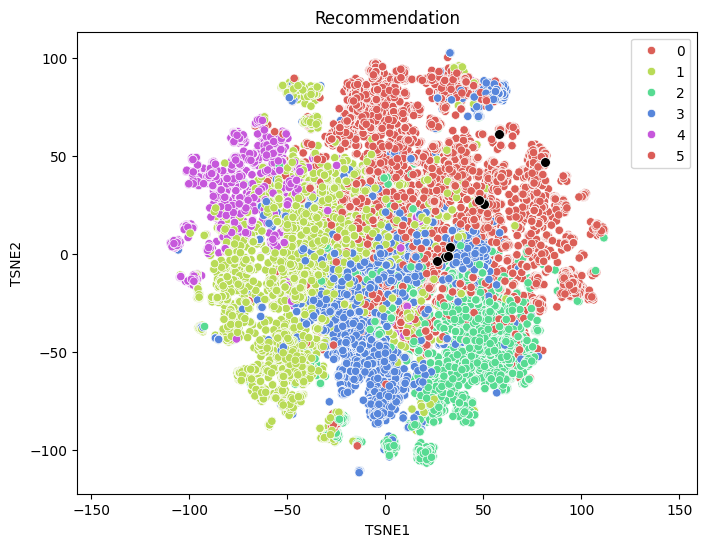

In [48]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Recommendation')

# Average Correct Predictions

In [49]:
def countCorrectPredictions(df, totalSamples, increment, kmeans):
   correctPredictions = 0
   accuracyProgress = []

   for i in range(1, totalSamples + 1):
      sample = df.sample().values[0]
      sampleEmbedding = sample[4]
      npSampleEmbedding = np.array(sampleEmbedding, dtype=np.float32).reshape(1, -1)
      
      pc = predictCluster(npSampleEmbedding, kmeans)[0]
      similarities = cosine_similarity([sampleEmbedding], list(df['embedding']))
      similarities = list(enumerate(similarities[0]))
      similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
      articleIndex = [i[0] for i in similarities]
      recommendations = df.iloc[articleIndex]
      
      recommendedCluster = recommendations['cluster'].values
      correctPredictions += np.sum(recommendedCluster == pc)
      
      if i % increment == 0:
         accuracy = correctPredictions / (i * 10)  
         accuracyProgress.append((i, accuracy))

   return accuracyProgress

def plotAccuracyProgress(accuracyProgress):
   x = [point[0] for point in accuracyProgress]
   y = [point[1] for point in accuracyProgress]

   plt.figure(figsize=(10, 6))
   plt.plot(x, y, marker='o', linestyle='-', color='b')
   plt.title('Accuracy in Increments of 100 Samples')
   plt.xlabel('Number of Samples Processed')
   plt.ylabel('Accuracy')
   plt.ylim(0, 1)
   plt.grid(True)
   plt.show()

In [ ]:
accuracyProgress = countCorrectPredictions(df, 1000, 100, kmeans)

In [ ]:
plotAccuracyProgress(accuracyProgress)

# Finding Dissimilar Articles
Cosine Similarity method (10 most dissimilar based on cosine)

In [52]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
25376,25376,kumparan,Ramalan Zodiak Virgo Bulan April 2023,3,0.731886
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,0.733455
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,0.735458
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan ...,3,0.735710
8201,8201,kumparan,Biagi Rilis Lagu Galau Berjudul Never Be Fine,3,0.735749
2456,2456,kumparan,"Penyebab, Cara Mengatasi, dan Cara Cegah Sakit...",3,0.736386
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat ...,3,0.737098
13374,13374,cnbcindonesia,"Habis Turun, Harga Emas Diramal Terbang ke Rp ...",4,0.737956
8845,8845,kumparan,"Panduan Berpakaian Bagi Bayi Baru Lahir, Ibu W...",3,0.738174
26309,26309,kumparan,Diskon iPhone 14 Series hingga Rp 2 Juta di iB...,1,0.738246


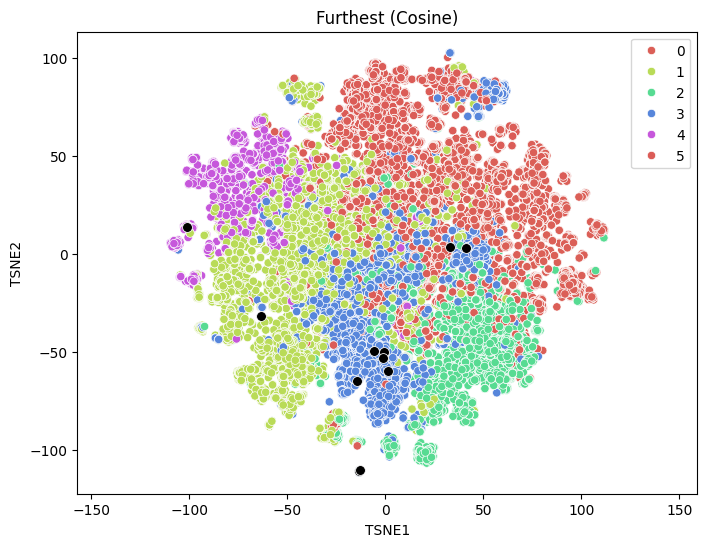

In [53]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Furthest (Cosine)')

Antipode Method (10 nearest to opposite of embedding)

In [54]:
antipode_embedding = -np.array(sampleEmbedding)
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
25376,25376,kumparan,Ramalan Zodiak Virgo Bulan April 2023,3,-0.731886
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,-0.733455
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,-0.735458
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan ...,3,-0.735710
8201,8201,kumparan,Biagi Rilis Lagu Galau Berjudul Never Be Fine,3,-0.735749
2456,2456,kumparan,"Penyebab, Cara Mengatasi, dan Cara Cegah Sakit...",3,-0.736386
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat ...,3,-0.737098
13374,13374,cnbcindonesia,"Habis Turun, Harga Emas Diramal Terbang ke Rp ...",4,-0.737956
8845,8845,kumparan,"Panduan Berpakaian Bagi Bayi Baru Lahir, Ibu W...",3,-0.738174
26309,26309,kumparan,Diskon iPhone 14 Series hingga Rp 2 Juta di iB...,1,-0.738246


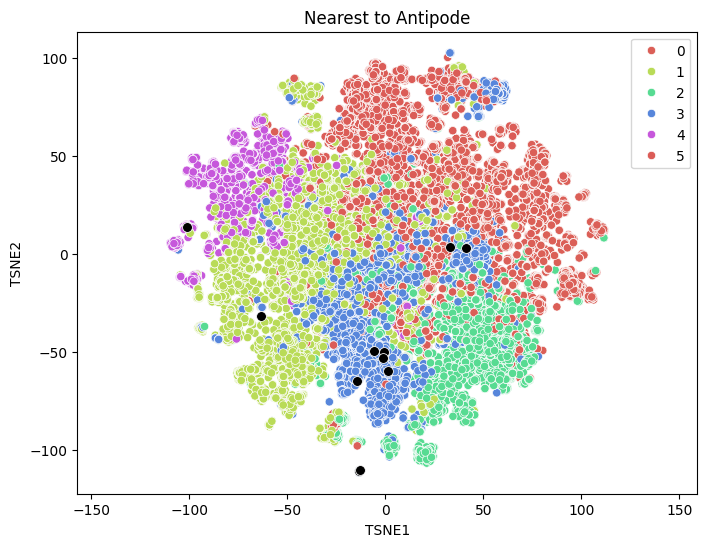

In [55]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
    
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Nearest to Antipode')

Euclidean Method (Finding 10 furthest distance)

In [56]:
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'euclidean', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
25376,25376,kumparan,Ramalan Zodiak Virgo Bulan April 2023,3,1.861121
27364,27364,kumparan,Apa Itu Family Issues dan Bagaimana Cara Menga...,3,1.861964
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan ...",3,1.863039
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan ...,3,1.863175
8201,8201,kumparan,Biagi Rilis Lagu Galau Berjudul Never Be Fine,3,1.863195
2456,2456,kumparan,"Penyebab, Cara Mengatasi, dan Cara Cegah Sakit...",3,1.863537
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat ...,3,1.863919
13374,13374,cnbcindonesia,"Habis Turun, Harga Emas Diramal Terbang ke Rp ...",4,1.864380
8845,8845,kumparan,"Panduan Berpakaian Bagi Bayi Baru Lahir, Ibu W...",3,1.864497
26309,26309,kumparan,Diskon iPhone 14 Series hingga Rp 2 Juta di iB...,1,1.864535


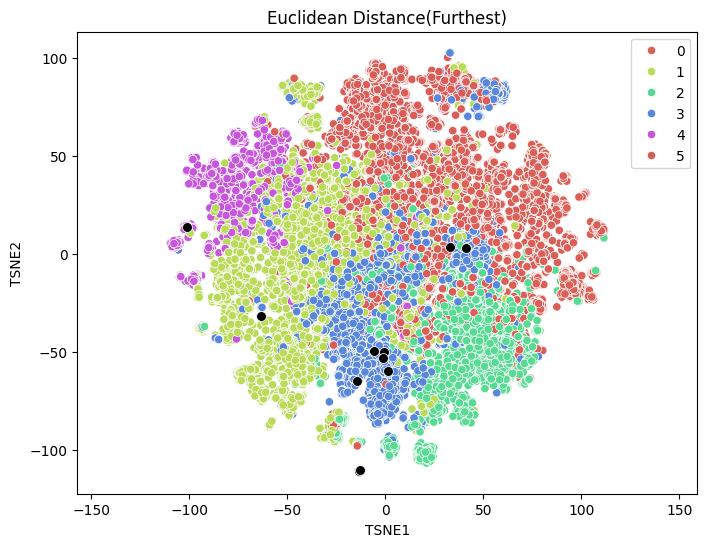

In [57]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Euclidean Distance(Furthest)')

# Two Most Dissimilar News Articles
- To check their position in graph

In [58]:
def MostDissimilarCosine(df):
    similarity_matrix = cosine_similarity(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(similarity_matrix, np.inf)
    min_similarity = np.min(similarity_matrix)
    row, col = np.unravel_index(np.argmin(similarity_matrix), similarity_matrix.shape)
    return row, col, min_similarity

In [59]:
def MostDissimilarEuclidean(df):
    distance_matrix = euclidean_distances(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(distance_matrix, -np.inf)
    min_similarity = np.max(distance_matrix)
    row, col = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    return row, col, min_similarity

Cosine similarity method

In [ ]:
row, col, min_similarity = MostDissimilarCosine(df)
print(f"Most Dissimilar Pair of Articles by Cosine Similarity: {row}, {col}")
print(f"Cosine similarity: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

In [ ]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[row, col], title='Most Dissimilar Cosine')

In [ ]:
# %matplotlib widget

In [ ]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster', highlight_points=[row, col])

In [64]:
# %matplotlib inline

Euclidean Method (Results show the same)

In [ ]:
row, col, min_similarity = MostDissimilarEuclidean(df)

In [ ]:
print(f"Most Dissimilar Pair of Articles by Euclidean Distance: {row}, {col}")
print(f"Euclidean Distance: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

# Run the sample and 10 recommendations to model

In [147]:
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index)
sampleEmbedding = sample.iloc[0]['embedding']
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
18313,18313,kumparan,Keluarga Besar Alumni Universitas Gadjah Mada ...,2,0.887780
15464,15464,kumparan,Pertamina Group Gandeng FJPI Berikan Trauma He...,2,0.887199
20623,20623,kumparan,Korban Kebakaran di Desa Pasir Mempawah Mengun...,2,0.884591
6824,6824,kumparan,Mak Ganjar Gelar Sedekah Bumi dan Pentas Reog ...,3,0.884123
11804,11804,suara,Jaga Ketahanan Pangan Melalui Kegiatan Sedekah...,2,0.882601
13967,13967,kumparan,"Peduli Korban Kebakaran Pasar Baru, RU VII Kas...",2,0.881921
29893,29893,okezone,Relawan Ganjar Galang Dukungan di Jawa Timur,5,0.878539
2260,2260,kumparan,Bantu Pulihkan Ekonomi Korban Kebakaran Plumpa...,2,0.877811
15351,15351,okezone,"Beri Gerobak Perindo ke Penjual Gorengan, Mahf...",1,0.877597
30865,30865,suara,"Jelang Idul Fitri, 1.000 Paket Sembako Disedia...",1,0.877206


In [148]:
model = load_model('../model/hoax_detection_A3.h5')
with open('../model/tokenizer_A3.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
allArticles = [sampleText] + list(recommendations['content'])

allSequences = tokenizer.texts_to_sequences(allArticles)
paddedAllSequences = pad_sequences(allSequences, maxlen=100, padding='post', truncating='post')

predictedProbabilities = model.predict(paddedAllSequences)
predictedClasses = (predictedProbabilities > 0.5).astype(int)
predictions = ["Fake" if pred == 1 else "Real" for pred in predictedClasses]
recommendations['newsRealorFake'] = predictions[1:]
print(recommendations[['source', 'title', 'newsRealorFake']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
         source                                              title  \
18313  kumparan  Keluarga Besar Alumni Universitas Gadjah Mada ...   
15464  kumparan  Pertamina Group Gandeng FJPI Berikan Trauma He...   
20623  kumparan  Korban Kebakaran di Desa Pasir Mempawah Mengun...   
6824   kumparan  Mak Ganjar Gelar Sedekah Bumi dan Pentas Reog ...   
11804     suara  Jaga Ketahanan Pangan Melalui Kegiatan Sedekah...   
13967  kumparan  Peduli Korban Kebakaran Pasar Baru, RU VII Kas...   
29893   okezone       Relawan Ganjar Galang Dukungan di Jawa Timur   
2260   kumparan  Bantu Pulihkan Ekonomi Korban Kebakaran Plumpa...   
15351   okezone  Beri Gerobak Perindo ke Penjual Gorengan, Mahf...   
30865     suara  Jelang Idul Fitri, 1.000 Paket Sembako Disedia...   

      newsRealorFake  
18313           Real  
15464           Real  
20623           Real  
6824            Fake  
11804           Fake  
13967           Real  
29893           Real  
2260   

In [150]:
with open('../model/bias_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

interpreter = tf.lite.Interpreter(model_path='../model/bias_detection_lstm.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
newSequences = tokenizer.texts_to_sequences(allArticles)
maxLen = 30
new_padded = pad_sequences(newSequences, maxlen=maxLen)

new_padded = new_padded.astype('float32')

results = []

for i, article_padded in enumerate(new_padded):
    interpreter.set_tensor(input_details[0]['index'], article_padded.reshape(1, -1))
    interpreter.invoke()
    
    predictionsTfLite = interpreter.get_tensor(output_details[0]['index'])
    
    predictedLabelsTfLite = 1 if predictionsTfLite[0] > 0.5 else 0
    textLabel = "Bias" if predictedLabelsTfLite == 1 else "Netral"
    
    results.append(textLabel)

recommendations['isBiased'] = results[1:] 

print(recommendations[['source', 'title', 'newsRealorFake', 'isBiased']])

         source                                              title  \
18313  kumparan  Keluarga Besar Alumni Universitas Gadjah Mada ...   
15464  kumparan  Pertamina Group Gandeng FJPI Berikan Trauma He...   
20623  kumparan  Korban Kebakaran di Desa Pasir Mempawah Mengun...   
6824   kumparan  Mak Ganjar Gelar Sedekah Bumi dan Pentas Reog ...   
11804     suara  Jaga Ketahanan Pangan Melalui Kegiatan Sedekah...   
13967  kumparan  Peduli Korban Kebakaran Pasar Baru, RU VII Kas...   
29893   okezone       Relawan Ganjar Galang Dukungan di Jawa Timur   
2260   kumparan  Bantu Pulihkan Ekonomi Korban Kebakaran Plumpa...   
15351   okezone  Beri Gerobak Perindo ke Penjual Gorengan, Mahf...   
30865     suara  Jelang Idul Fitri, 1.000 Paket Sembako Disedia...   

      newsRealorFake isBiased  
18313           Real     Bias  
15464           Real   Netral  
20623           Real     Bias  
6824            Fake     Bias  
11804           Fake     Bias  
13967           Real     Bias  
29893

In [152]:
documents = []
for index, row in recommendations.iterrows():
    document = Document(
    text=row['content'],
    doc_id=str(row['id']),
    metadata={
        'title': row['title'],
        'source': row['source'],
        'isBiased': row['isBiased'],
        'newsRealorFake': row['newsRealorFake']
    },
    embedding=(row['embedding'])
    )
    documents.append(document)

In [153]:
def createVectorIndex(documents):
    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir="../storage")

def loadVectorIndex():
    storage_context = StorageContext.from_defaults(persist_dir="../storage")
    index = load_index_from_storage(storage_context)
    return index

In [154]:
createVectorIndex(documents)

In [157]:
index = loadVectorIndex()

In [155]:
query_str = (
    "News Article Title: " + sample.iloc[0]['title'] + "\n"
    "News Article Content: " + sampleText + "\n"
    "News Article Source: " + sample.iloc[0]['source'] + "\n"
    "News Article Bias (Biased/Netral): " + recommendations.iloc[0]['isBiased'] + "\n"
    "News Article is detected to be: " + recommendations.iloc[0]['newsRealorFake']
)

print(query_str)

News Article Title: Bantu Korban kebakaran Pasar Baru Kota Sorong, FJPI Manokwari Galang Dana
News Article Content: Forum Jurnalis Perempuan Indonesia (FJPI) Cabang Manokwari melaksanakan aksi galang dana, di Perempatan Haji Bauw, Wosi, Manokwari, Sabtu (25/3). Aksi spontanitas ini dilaksanakan dalam rangka membantu korban kebakaran di Kampung Makassar, Kompleks Pasar Baru, Kota Sorong, Papua Barat Daya. Ketua FJPI Cabang Manokwari Fenty Rumbiak mengatakan, aksi penggalangan dana tersebut sebagai wujud kepedulian terhadap warga Kota Sorong, Provinsi Papua Barat Daya, yang terkena musibah kebakaran. "Untuk kegiatan yang kami lakukan hari ini ada dua, yang pertama kita galang dana  untuk membantu korban kebakaran dan yang kedua kita berbagi takjil kepada masyarakat yang melaksanakan ibadah puasa," ungkap Fenty. Menurutnya, aksi spontan yang dilaksanakan di pinggir jalan merupakan solidaritas jurnalis perempuan sebagai perpanjangan tangan dari masyarakat dan juga pemerintah. "Sedikit yang

In [ ]:
instruction = """
You are a news article analyzer capable of determining political bias by analyzing what is being highlighted. Please provide an explanation of why you chose a particular side, citing specific examples from the text that demonstrate its alignment. Do not speak in first person.

Assess the article using the following bias ratings:
Neutral: The article presents balanced coverage with no clear lean toward any political side, offering both governmental and opposition views fairly or taking no sides. It avoids strong language or overt opinions, focusing on facts and events without significant framing or bias.
Progressive: The article tends to highlight progressive social, economic, or political reforms. It may support the expansion of civil rights, greater equality, or address sensitive issues like minority rights or environmental concerns. A progressive stance is often more critical of the status quo and may push for change.
Conservative: The article tends to highlight traditional values, maintaining or returning to the status quo. It often aligns with religious or nationalistic views and may criticize progressive movements or policies that challenge these traditional values.
Critical: The article critiques the government. While it may be negative or adversarial, it can also be constructive in its criticism, highlighting flaws, mismanagement, or policies that need reform. Critical content does not shy away from highlighting issues or injustices.

Expected Answer:
Bias Rating: Rate the article and explain your choice of Bias (if it is biased as specified) with brief examples from the text.
Hoax Rating: Compare the article with the information you have. Explain which part of the given article is different if any.
Key Indicators of Bias: Explain if there are any opinionated content, selective facts, extreme language, persuasive tactics, unsupported claims, anonymity, entertainment-based content, or disguised sales pitches.
Conclusion: Summarize findings of bias and hoax, mentioning if there were any nuances or mixed signals.
"""

In [ ]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

response_synthesizer = get_response_synthesizer()

class CustomRetrieverQueryEngine(RetrieverQueryEngine):
    def query(self, query_text: str):
        retrieverResults = self.retriever.retrieve(query_text)
        return super().query(query_text)

query_engine = CustomRetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.5)],
)

Bias Rating: The article is biased. It leans towards a progressive bias as it highlights the efforts of Forum Jurnalis Perempuan Indonesia (FJPI) Cabang Manokwari in organizing a fundraising event to assist the victims of the fire in Kota Sorong. The article emphasizes the solidarity and support provided by the female journalists, portraying them in a positive light for their charitable actions.

Hoax Rating: The article is real and aligns with the provided context information.

Key Indicators of Bias: The article showcases a positive image of the FJPI Cabang Manokwari and their charitable activities, using language that emphasizes their compassion and support for the fire victims. It focuses on the progressive values of community assistance and solidarity.

Conclusion: The article exhibits a progressive bias by highlighting the philanthropic actions of the FJPI Cabang Manokwari in aiding the fire victims, portraying them in a positive and supportive manner.


In [ ]:
response = query_engine.query(instruction + query_str)
print(response)